In [2]:
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import numpy as np
import sklearn

In [3]:
from confidenceinterval import classification_report_with_ci
from confidenceinterval.bootstrap import bootstrap_ci


#### small demo of CI lib

In [511]:
y_true = [0, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1]
y_pred = [0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 2, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1]
# You can specify a random generator for reproducability, or pass None
random_generator = np.random.default_rng()
bootstrap_ci(y_true=y_true,
             y_pred=y_pred,
             metric=sklearn.metrics.accuracy_score, # change to any metrics
             metric_average='n.a.', # if multi-class you can specify the average method, i.e. ‘micro’, ‘macro’, ‘samples’, ‘weighted’
             confidence_level=0.95,
             n_resamples=9999,
             method='bootstrap_bca',
             random_state=random_generator)

(0.90625, (0.75, 0.96875))

In [514]:
recall_weighted, r_ci_weighted = bootstrap_ci(y_true=y_true,
                                     y_pred=y_pred,
                                     metric=sklearn.metrics.recall_score,
                                     metric_average='weighted',
                                     confidence_level=0.95,
                                     n_resamples=9999,
                                     method='bootstrap_bca',
                                     random_state=random_generator)
recall_weighted, r_ci_weighted

(0.90625, (0.75, 0.96875))

In [518]:
sklearn.metrics.recall_score(y_true, y_pred, average='weighted')

0.90625

In [516]:
accuracy, accuracy_ci = bootstrap_ci(y_true=y_true,
                         y_pred=y_pred,
                         metric=sklearn.metrics.accuracy_score,
                         metric_average='n.a.',
                         confidence_level=0.95,
                         n_resamples=9999,
                         method='bootstrap_bca',
                         random_state=random_generator)
accuracy, accuracy_ci

(0.90625, (0.75, 0.96875))

In [519]:
sklearn.metrics.accuracy_score(y_true, y_pred)

0.90625

In [279]:
classification_report_with_ci(y_true, y_pred)

# Evaluate Multi-Class


## Load and combine multiple files with predictions

In [657]:
# each of the sub-lists will determine the reading of the relevant files
prompt_ids_to_eval = [["P1"], ["P2", "P3_1", "P3_2"], ["P3_3", "P3_4", "P4_1", "P4_2"], ["P5"], ["P6"], ["P7"], ["P9", "P9_1", "P10"], ["P11", "P11_1", "P11_2", "P11_3"], ["P11_4", "P11_5", "P12"], ["P12_1"], ["P12_2"]]

model = "gpt-3.5-turbo" #"gpt-3.5-turbo" "gpt-4-turbo-preview"
data_type = "enriched_kw"

In [610]:
# Define a function to process each sublist
def process_prompt_ids(prompt_ids):
    # Create the list of prediction columns based on the prompt IDs
    prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids]
    # Specify the basic columns to include in the DataFrame
    basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
    # Combine basic columns with the dynamically generated prediction columns
    columns_to_read = basic_columns + prediction_columns
    # Read the CSV file
    df = pd.read_csv(f"predictions/{model}_{data_type}_test_outputs_{'_'.join(prompt_ids)}.csv")[columns_to_read]
    return df, prediction_columns
    
# Initialize an empty set to store all prediction columns
all_prediction_columns = set()

# Process the first sublist to initialize the big DataFrame
df, prediction_columns = process_prompt_ids(prompt_ids_to_eval[0])
# Add the prediction columns to the set
all_prediction_columns.update(prediction_columns)

# Iterate over the remaining sublists
for prompt_ids in prompt_ids_to_eval[1:]:
    # Process the current sublist
    df_single_file, prediction_columns = process_prompt_ids(prompt_ids)
    # Merge the big DataFrame with the current DataFrame on 'pmid' using a left join
    df = pd.merge(df, df_single_file[['pmid'] + prediction_columns], on='pmid', how='left')
    # Keep only the prediction columns from the current DataFrame
    #big_df = big_df[['pmid', 'accepted_label', 'multi_label', 'binary_label'] + prediction_columns]
    # Add the prediction columns to the set
    all_prediction_columns.update(prediction_columns)

# Convert the set of prediction columns to a list
all_prediction_columns = list(all_prediction_columns)
df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3_1,gpt_predictions_P3_2,gpt_predictions_P3_3,gpt_predictions_P3_4,...,gpt_predictions_P10,gpt_predictions_P11,gpt_predictions_P11_1,gpt_predictions_P11_2,gpt_predictions_P11_3,gpt_predictions_P11_4,gpt_predictions_P11_5,gpt_predictions_P12,gpt_predictions_P12_1,gpt_predictions_P12_2
0,12047012,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Non-systematic review,...,Non-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Non-systematic-review,Non-systematic-review,Non-systematic review,Non-systematic review,Non-systematic-review,Non-systematic-review
1,28832188,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Animal-other,...,Human-systematic-review,Animal-other,Animal-other,Animal-other,Animal-other,Animal-drug-intervention,Remaining,Animal-other,Animal-drug-intervention,Animal-drug-intervention
2,17678496,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Non-systematic review,Non-systematic review,...,Human-systematic-review,Human-non-RCT-non-drug-intervention,Non-systematic review,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention
3,25649308,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-RCT-drug-intervention,Human-non-RCT-drug-intervention,Human-systematic-review,Human-non-RCT-drug-intervention,...,Human-systematic-review,Human-non-RCT-drug-intervention,Human-non-RCT-drug-intervention,Human-non-RCT-drug-intervention,Human-non-RCT-drug-intervention,Human-systematic-review,Human-systematic-review,Human-systematic-review,Human-systematic-review,Human-RCT-drug-intervention
4,6312596,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Non-systematic review,...,Human-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Non-systematic-review,Remaining,Non-systematic review,Human-non-RCT-non-drug-intervention,Non-systematic-review,Remaining


In [611]:
prediction_columns = all_prediction_columns

## Load individual file with predictions

Skip the below if you have already loaded multiple files!

In [561]:
prompt_ids_to_eval = ["P1_HIERARCHY","P2_HIERARCHY"] #["P1", "P4_1", "P5"] # ["P6", "P7", "P11_3", "P11_4"]
model = "gpt-3.5-turbo" #"gpt-3.5-turbo" "gpt-4-turbo-preview"
data_type = "enriched_kw" # change when evaluating enriched without kw/ not enriched to be able to load and save the correct names

In [562]:
# Create the list of prediction columns based on the prompt IDs
prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids_to_eval]
# Specify the basic columns to include in the DataFrame
basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
# Combine basic columns with the dynamically generated prediction columns
columns_to_read = basic_columns + prediction_columns

df = pd.read_csv(f"predictions/{model}_{data_type}_test_outputs_P3_{'_'.join(prompt_ids_to_eval)}_hierarchical.csv")[columns_to_read]

In [563]:
columns_to_read

['pmid',
 'accepted_label',
 'multi_label',
 'binary_label',
 'gpt_predictions_P1_HIERARCHY',
 'gpt_predictions_P2_HIERARCHY']

In [565]:
df.shape

(534, 6)

In [566]:
df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1_HIERARCHY,gpt_predictions_P2_HIERARCHY
0,32147509,Non-systematic-review,1,0,Animal-systematic-review,Animal-systematic-review
1,16312938,Non-systematic-review,1,0,Animal-other,Animal-other
2,23811310,Non-systematic-review,1,0,Animal-other,Animal-other
3,27534431,Remaining,0,0,Animal-other,Animal-other
4,8291133,Remaining,0,0,Animal-other,Animal-other


## Map predictions to numerical

In [613]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}

In [614]:
numerical_to_label = {v: f"{k}" for k, v in label_to_numerical.items()}
numerical_to_label

{0: 'Remaining',
 1: 'Non-systematic-review',
 2: 'Human-non-RCT-non-drug-intervention',
 3: 'Human-non-RCT-drug-intervention',
 4: 'Human-case-report',
 5: 'Animal-other',
 6: 'Animal-drug-intervention',
 7: 'Human-systematic-review',
 8: 'In-vitro-study',
 9: 'Human-RCT-non-drug-intervention',
 10: 'Animal-non-drug-intervention',
 11: 'Human-RCT-drug-intervention',
 12: 'Clinical-study-protocol',
 13: 'Human-RCT-non-intervention'}

In [615]:
import difflib
def map_label_fuzzy(label, label_dict):
    #label = label.lower().replace('-', '').replace('_', ' ').strip()
    best_match = difflib.get_close_matches(label, label_dict.keys(), n=1, cutoff=0.6)
    if best_match:
        #print(f'{label} matched to {best_match[0]}')
        return label_dict[best_match[0]]
    return -1

In [616]:
map_label_fuzzy("RCT-drug-intervention", label_to_numerical)

11

In [618]:
def map_label_to_numerical(label, label_dict):
    # Check if label is a dictionary
    if isinstance(label, dict):
        print(label)
        # Extract the label with the highest score/probability
        highest_label = max(normalized_label, key=label.get)
        return label_dict.get(highest_label, -1)
    else:
         # Normalize label
        normalized_label = label.replace(',', '').strip().replace(' ', '-')#.strip()
        # Directly map string labels to numerical IDs
        numerical_label = label_dict.get(label, -1)
        # Fuzzy match if no direct mapping possible
        if numerical_label == -1:
            numerical_label = map_label_fuzzy(normalized_label, label_dict)
        # If fuzzy match did not work, check if the label string contains the key 'label' and use it to split the string; keep everything to the right as the potential label
        if numerical_label == -1:
            if 'label' in label:
                label_part = label.split('label')[1]
                numerical_label = map_label_fuzzy(label_part, label_dict)
        return numerical_label
        
# Convert accepted labels to numerical
df['accepted_label_numerical'] = df['accepted_label'].apply(lambda x: map_label_to_numerical(x, label_to_numerical))


for col in prediction_columns:
    df[f'{col}_numerical'] = df[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical))

df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3_1,gpt_predictions_P3_2,gpt_predictions_P3_3,gpt_predictions_P3_4,...,gpt_predictions_P3_4_numerical,gpt_predictions_P10_numerical,gpt_predictions_P11_2_numerical,gpt_predictions_P12_2_numerical,gpt_predictions_P12_numerical,gpt_predictions_P11_numerical,gpt_predictions_P1_numerical,gpt_predictions_P5_numerical,gpt_predictions_P11_1_numerical,gpt_predictions_P4_2_numerical
0,12047012,Non-systematic-review,1,0,Non-systematic-review,Non-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Non-systematic review,...,1,1,1,1,1,1,1,1,1,1
1,28832188,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Animal-other,...,5,7,5,6,5,5,7,5,5,0
2,17678496,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Non-systematic review,Non-systematic review,...,1,7,2,2,2,2,7,2,1,2
3,25649308,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-RCT-drug-intervention,Human-non-RCT-drug-intervention,Human-systematic-review,Human-non-RCT-drug-intervention,...,3,7,3,11,7,3,7,7,3,7
4,6312596,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Non-systematic review,Non-systematic review,Non-systematic review,Non-systematic review,...,1,7,1,0,2,1,7,0,1,1


In [620]:
def is_list_of_lists(lst):
    return all(isinstance(sublist, list) for sublist in lst)

if is_list_of_lists(prompt_ids_to_eval):
    # Flatten the list of lists
    prompt_ids_to_eval_flat = [item for sublist in prompt_ids_to_eval for item in sublist]
    # Create a string suffix for the CSV file name
    csv_file_suffix = '_'.join(prompt_ids_to_eval_flat)
else:
    csv_file_suffix = '_'.join(prompt_ids_to_eval)

In [624]:
csv_file_suffix = 'all_prompts' # when many prompts were loaded, the file name becomes too long and cannot be saved

In [625]:
df.to_csv(f"predictions/{model}_{data_type}_test_outputs_{'_'.join(csv_file_suffix)}_structured.csv")

### load and map best performing GPT results

In [626]:
df_gpt4_best = pd.read_csv("predictions/gpt-3.5-turbo_enriched_kw_test_test_outputs_P1_HIERARCHY_P2_HIERARCHY_structured.csv")
df_gpt4_best = df_gpt4_best.rename(columns={'gpt_predictions_P2_HIERARCHY_numerical': 'gpt_4_predictions_P2_HIERARCHY_numerical'})
df_gpt4_best = df_gpt4_best.rename(columns={'gpt_predictions_P2_HIERARCHY': 'gpt_4_predictions_P2_HIERARCHY'})

df_gpt3_best = pd.read_csv("predictions/gpt-4-turbo-preview_enriched_kw_test_test_outputs_P2_HIERARCHY_structured.csv")
df_gpt3_best = df_gpt3_best.rename(columns={'gpt_predictions_P2_HIERARCHY_numerical': 'gpt_3_predictions_P2_HIERARCHY_numerical'})
df_gpt3_best = df_gpt3_best.rename(columns={'gpt_predictions_P2_HIERARCHY': 'gpt_3_predictions_P2_HIERARCHY'})

df_gpt4_best.head()

,Unnamed: 0,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1_HIERARCHY,gpt_4_predictions_P2_HIERARCHY,accepted_label_numerical,gpt_predictions_P1_HIERARCHY_numerical,gpt_4_predictions_P2_HIERARCHY_numerical
0,0,32147509,Non-systematic-review,1,0,Animal-systematic-review,Animal-systematic-review,1,7,7
1,1,16312938,Non-systematic-review,1,0,Animal-other,Animal-other,1,5,5
2,2,23811310,Non-systematic-review,1,0,Animal-other,Animal-other,1,5,5
3,3,27534431,Remaining,0,0,Animal-other,Animal-other,0,5,5
4,4,8291133,Remaining,0,0,Animal-other,Animal-other,0,5,5


In [627]:
merged_df = pd.merge(df_gpt3_best, df_gpt4_best[['pmid', 'gpt_4_predictions_P2_HIERARCHY', 'gpt_4_predictions_P2_HIERARCHY_numerical']], on='pmid', how='left')
merged_df.drop(columns=['accepted_label_numerical', 'binary_label'], inplace=True)

merged_df

,Unnamed: 0,pmid,accepted_label,multi_label,gpt_3_predictions_P2_HIERARCHY,gpt_3_predictions_P2_HIERARCHY_numerical,gpt_4_predictions_P2_HIERARCHY,gpt_4_predictions_P2_HIERARCHY_numerical
0,0,32147509,Non-systematic-review,1,Animal-other,5,Animal-systematic-review,7
1,1,16312938,Non-systematic-review,1,Animal-non-drug-intervention,10,Animal-other,5
2,2,23811310,Non-systematic-review,1,Animal-other,5,Animal-other,5
3,3,33846423,Remaining,0,Animal-other,5,Animal-other,5
4,4,11909745,Remaining,0,Animal-other,5,Animal-other,5
...,...,...,...,...,...,...,...,...
529,529,24507711,Human-RCT-non-intervention,13,Human-non-RCT-non-drug-intervention,2,Remaining,0
530,530,28063795,Human-RCT-non-intervention,13,"Human, RCT non-drug-intervention",9,Human-RCT-drug-intervention,11
531,531,35488938,Human-RCT-non-intervention,13,Human-non-RCT-non-drug-intervention,2,Human-non-RCT-non-drug-intervention,2
532,532,16158009,Human-RCT-non-intervention,13,Human-non-RCT-non-drug-intervention,2,Human-case-report,4


In [628]:
merged_df.to_csv("predictions/top_performing_herarchical_GPT_structured.csv")

In [629]:
df[df['pmid'] == 19812460]

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3_1,gpt_predictions_P3_2,gpt_predictions_P3_3,gpt_predictions_P3_4,...,gpt_predictions_P3_4_numerical,gpt_predictions_P10_numerical,gpt_predictions_P11_2_numerical,gpt_predictions_P12_2_numerical,gpt_predictions_P12_numerical,gpt_predictions_P11_numerical,gpt_predictions_P1_numerical,gpt_predictions_P5_numerical,gpt_predictions_P11_1_numerical,gpt_predictions_P4_2_numerical
86,19812460,Human-RCT-non-drug-intervention,9,0,Human-RCT-non-drug-intervention,Human-RCT-non-drug-intervention,Human-RCT-non-drug-intervention,Human-RCT-non-drug-intervention,"Human, Non-RCT non-drug-intervention",Human-RCT-non-drug-intervention,...,9,9,9,9,9,9,9,2,9,9


#### Important: some labels from GPT could not be mapped to a target label

In [631]:
rows_with_minus_one = df[(df == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3_1,gpt_predictions_P3_2,gpt_predictions_P3_3,gpt_predictions_P3_4,...,gpt_predictions_P3_4_numerical,gpt_predictions_P10_numerical,gpt_predictions_P11_2_numerical,gpt_predictions_P12_2_numerical,gpt_predictions_P12_numerical,gpt_predictions_P11_numerical,gpt_predictions_P1_numerical,gpt_predictions_P5_numerical,gpt_predictions_P11_1_numerical,gpt_predictions_P4_2_numerical
87,24502822,Human-RCT-non-drug-intervention,9,0,Human-RCT-non-drug-intervention,{'The American journal of geriatric psychiatry...,Human-RCT-non-drug-intervention,Human-RCT-non-drug-intervention,Human-RCT-non-drug-intervention,Human-RCT-non-drug-intervention,...,9,9,9,9,9,9,9,9,9,9
253,33764656,Remaining,0,0,Human-non-RCT-non-drug-intervention,Human-systematic-review,Human-non-RCT-non-drug-intervention,Non-systematic review,{'journal': 'Autism research : official journa...,Non-systematic review,...,1,2,1,0,1,1,2,1,1,1


## Evaluate prompts

In [654]:
def evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, csv_file_suffix=None, digits=3):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report_with_ci(y_true, y_pred, numerical_to_label_map=numerical_to_label, round_ndigits = digits)
        
        # Create DataFrame from report
        report_df = pd.DataFrame(report)
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        report_df.set_index('class', inplace=True)
        summary = report_df.loc['weighted avg', ['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{prompt_id}_{eval_type}.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)

    if not csv_file_suffix:
        csv_file_suffix = '_'.join(prompt_ids_to_eval) + "_" + eval_type
    
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_{data_type}_test_per_class_{csv_file_suffix}_with_ci.csv")
    summary_df.to_csv(f"evaluations/{model}_{data_type}_test_summary_{csv_file_suffix}_with_ci.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df


In [655]:
if is_list_of_lists(prompt_ids_to_eval):
    # Flatten the list of lists
    prompt_ids_to_eval = [item for sublist in prompt_ids_to_eval for item in sublist]

In [656]:
prompt_ids_to_eval

['P1',
 'P2',
 'P3_1',
 'P3_2',
 'P3_3',
 'P3_4',
 'P4_1',
 'P4_2',
 'P5',
 'P6',
 'P7',
 'P9',
 'P9_1',
 'P10',
 'P11',
 'P11_1',
 'P11_2',
 'P11_3',
 'P11_4',
 'P11_5',
 'P12',
 'P12_1',
 'P12_2']

Evaluating  P1


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P2


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs

Evaluating  P3_1


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P3_2


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P3_3


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs

Evaluating  P3_4


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P4_1


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P4_2


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P5


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Evaluating  P6


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Evaluating  P7


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P9


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P9_1


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P10


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P11


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P11_1


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P11_2


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P11_3


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Evaluating  P11_4


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Evaluating  P11_5


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_cat

Evaluating  P12


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P12_1


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Evaluating  P12_2


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Results saved to evaluations/ and plots/ folders.


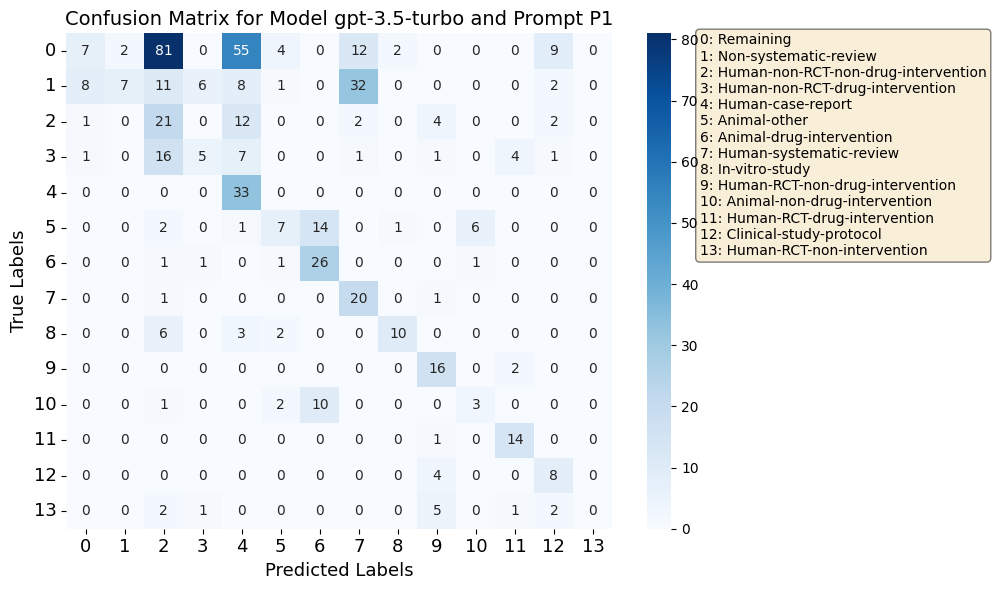

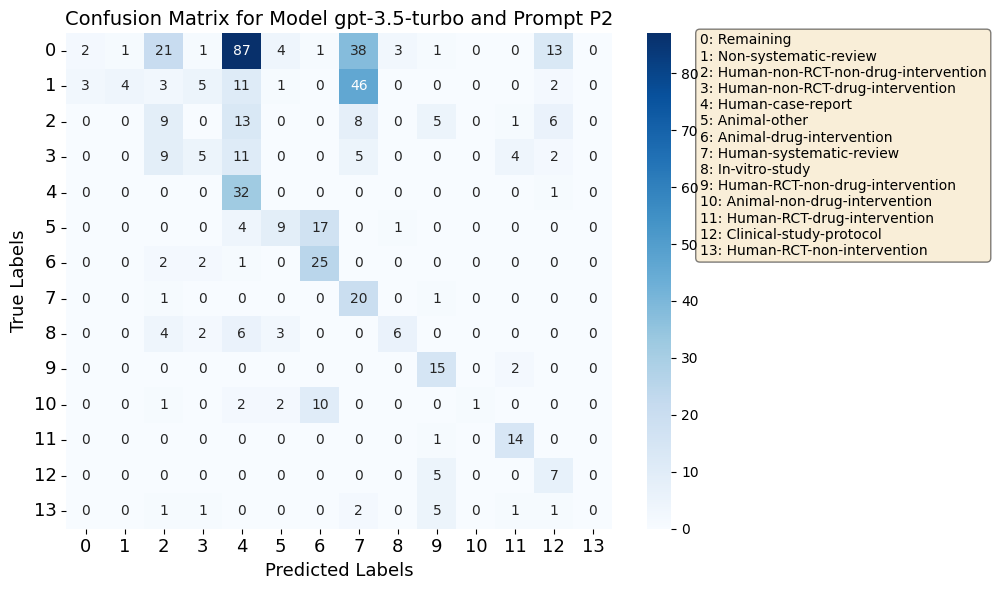

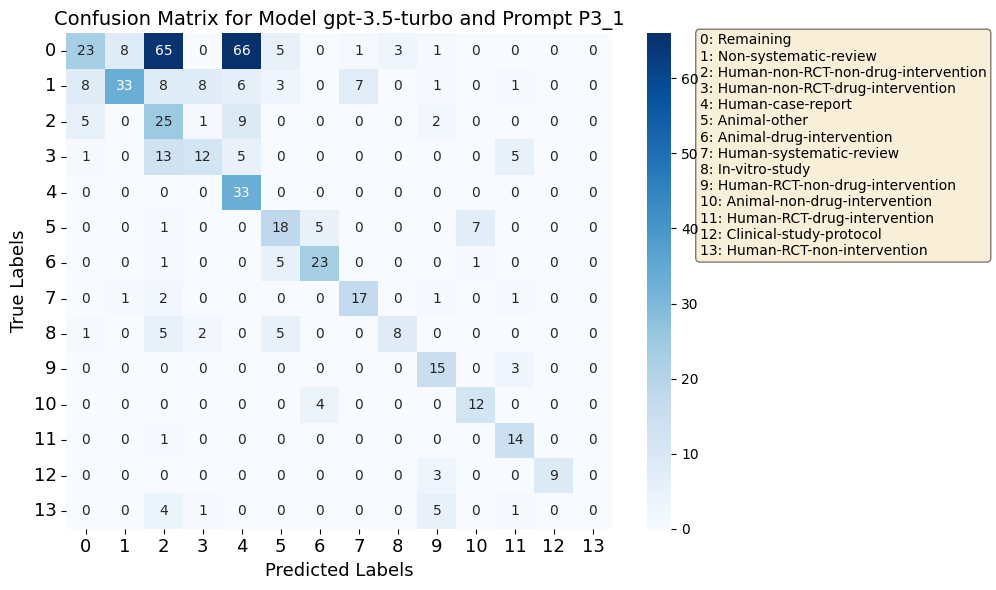

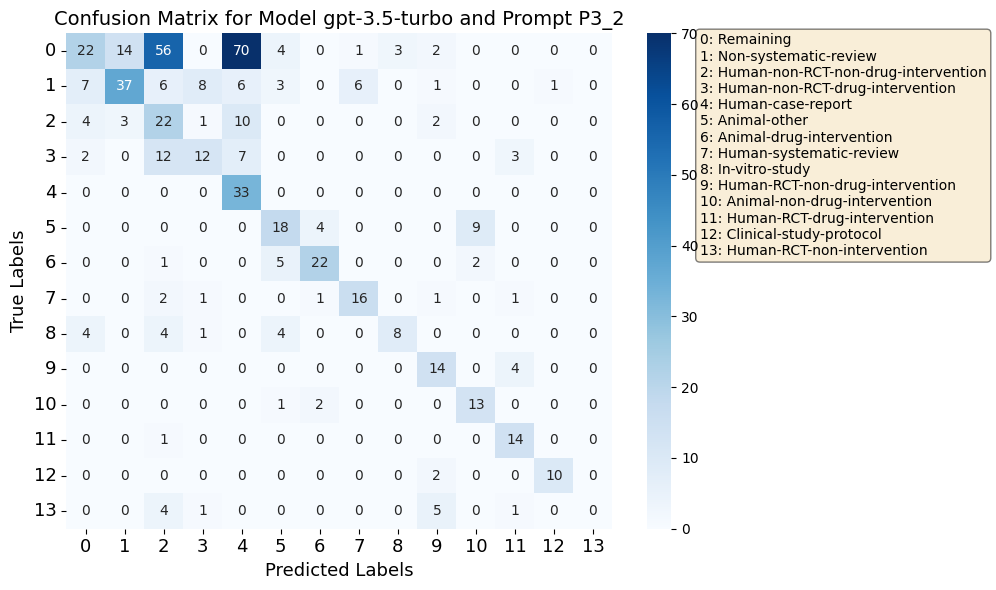

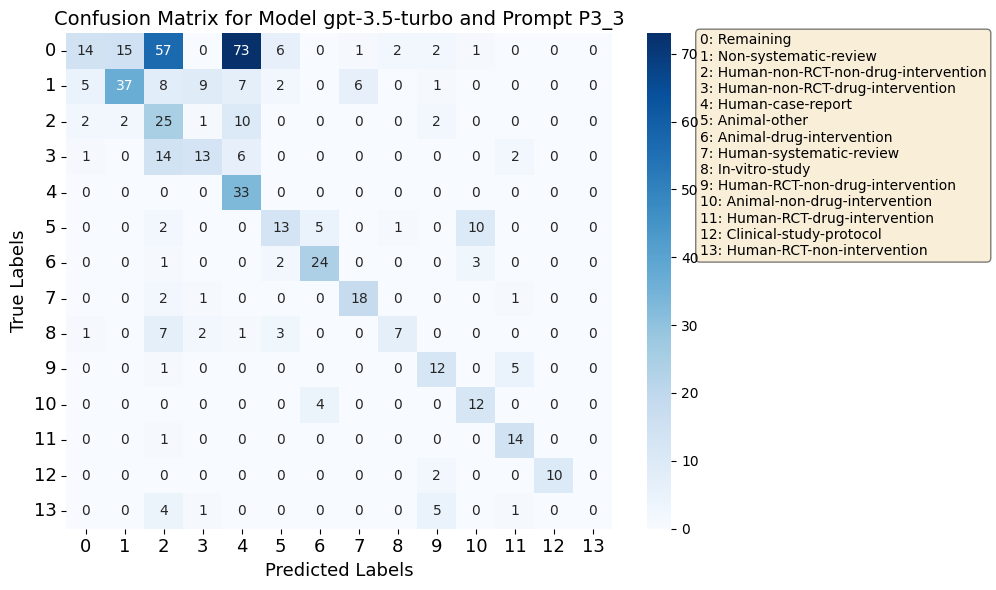

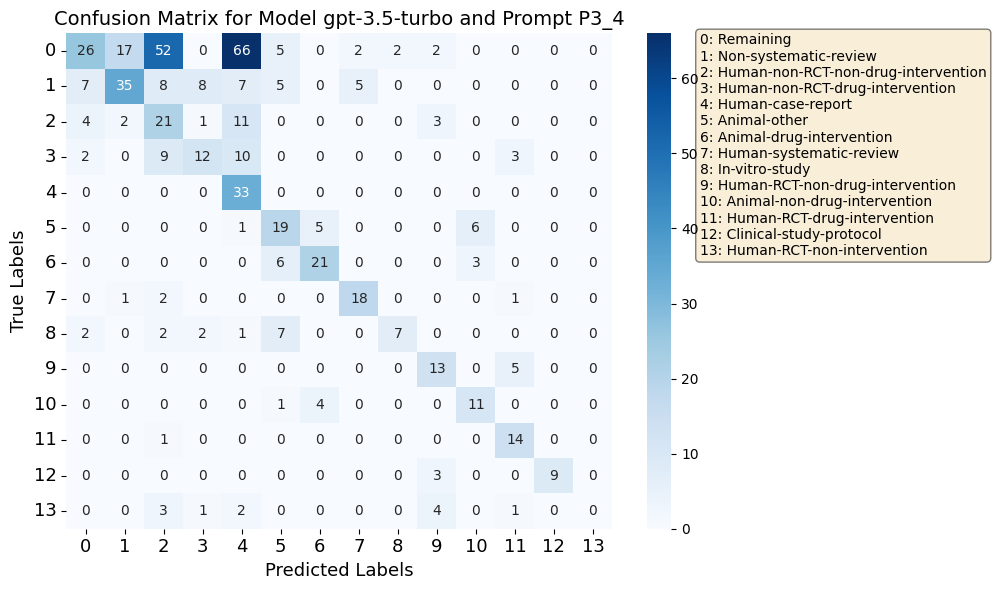

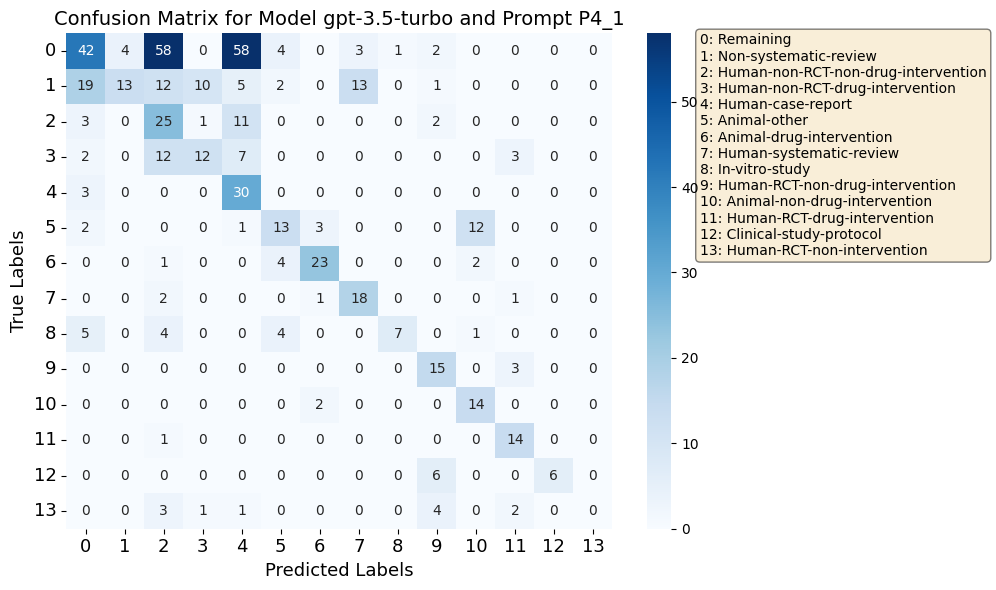

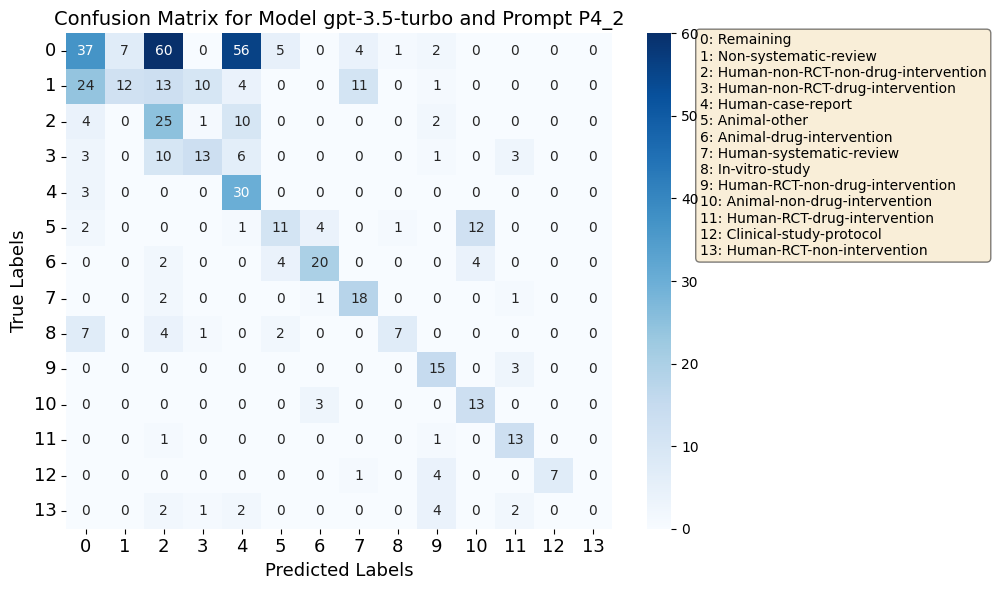

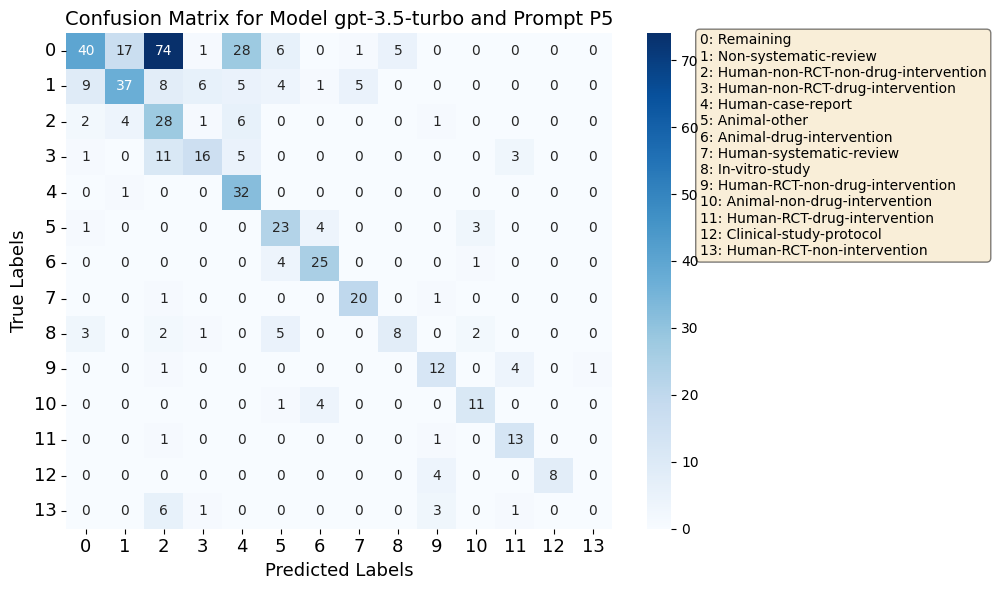

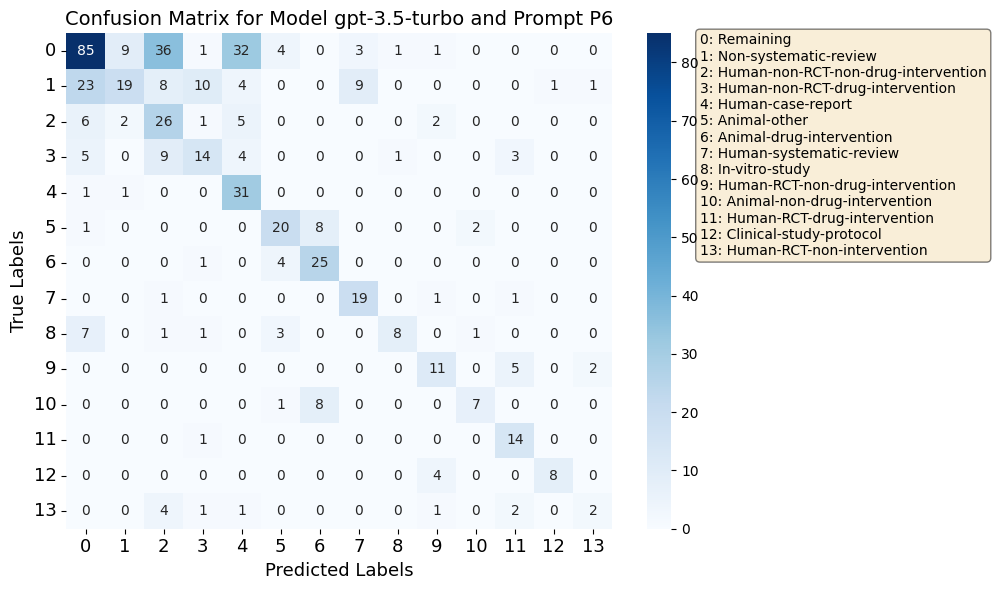

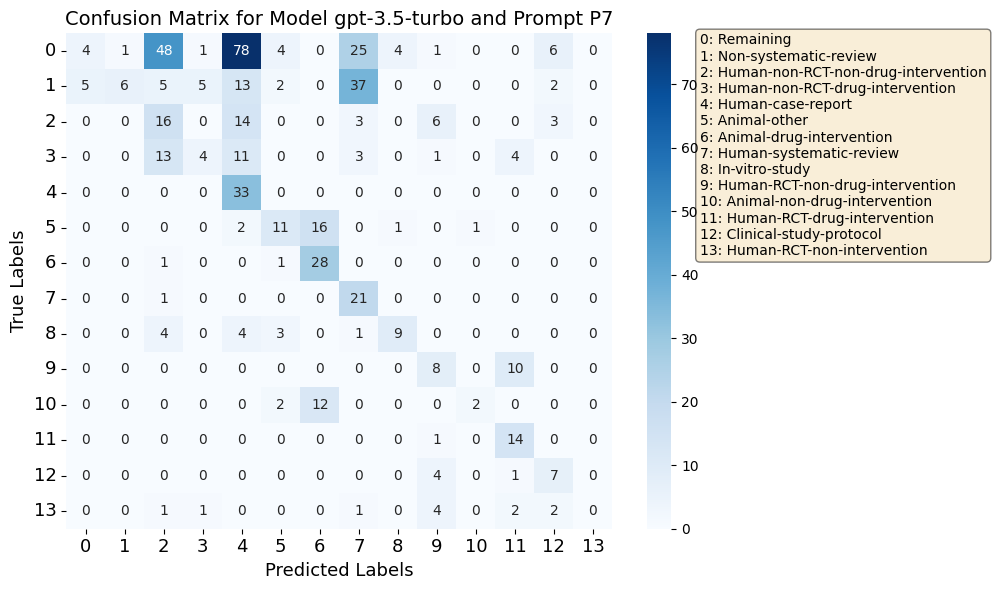

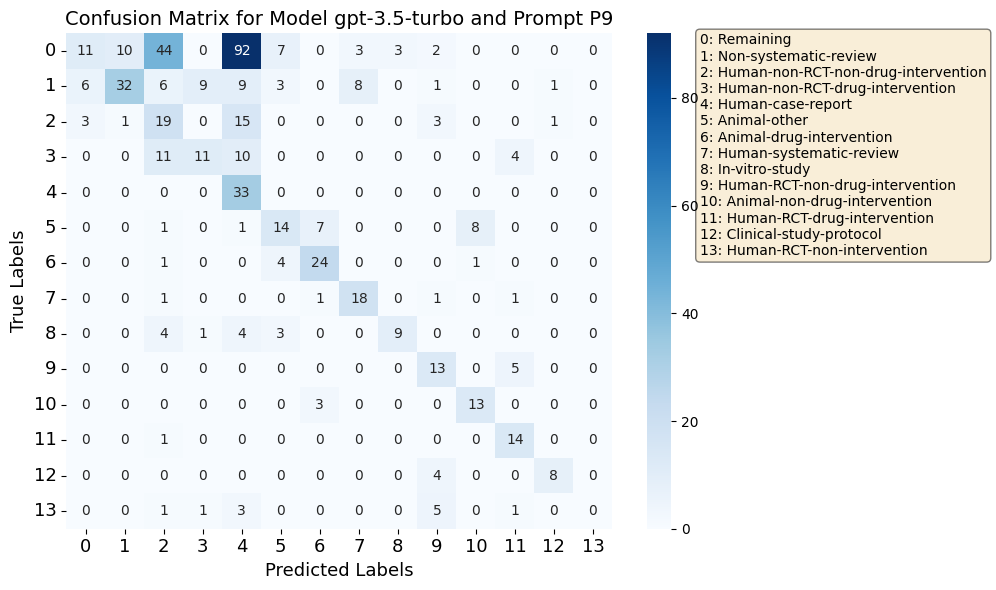

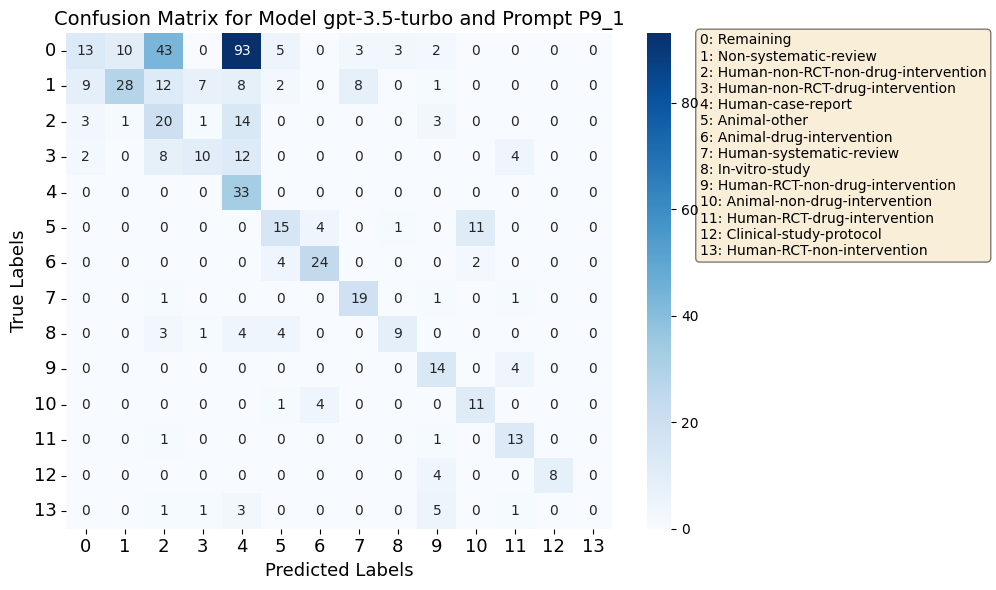

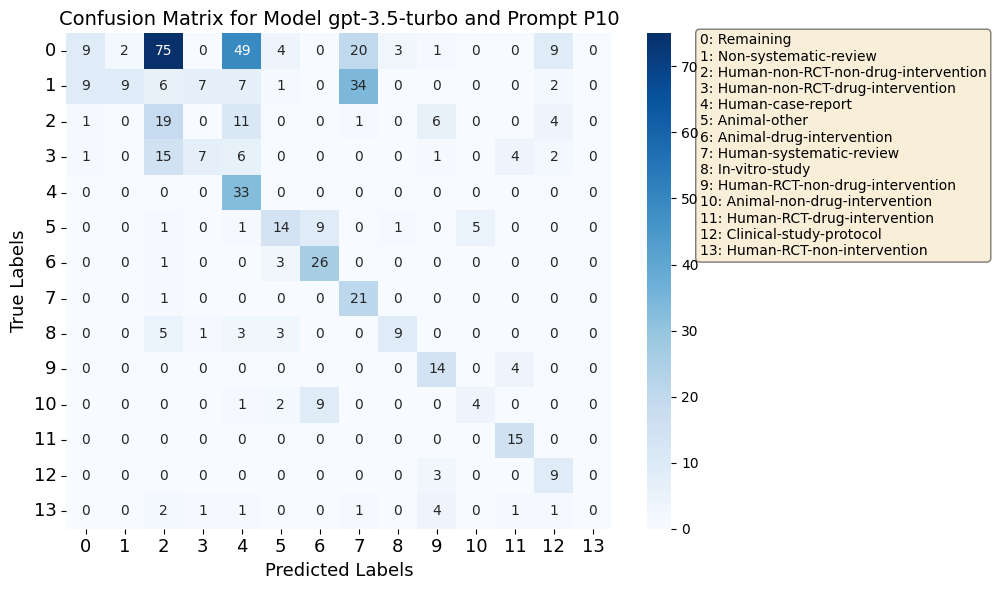

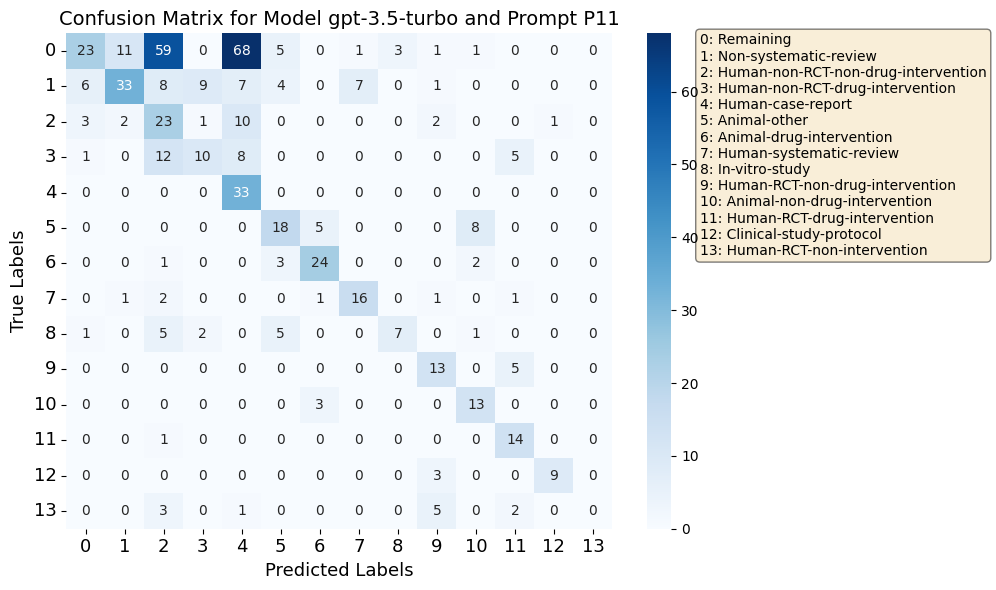

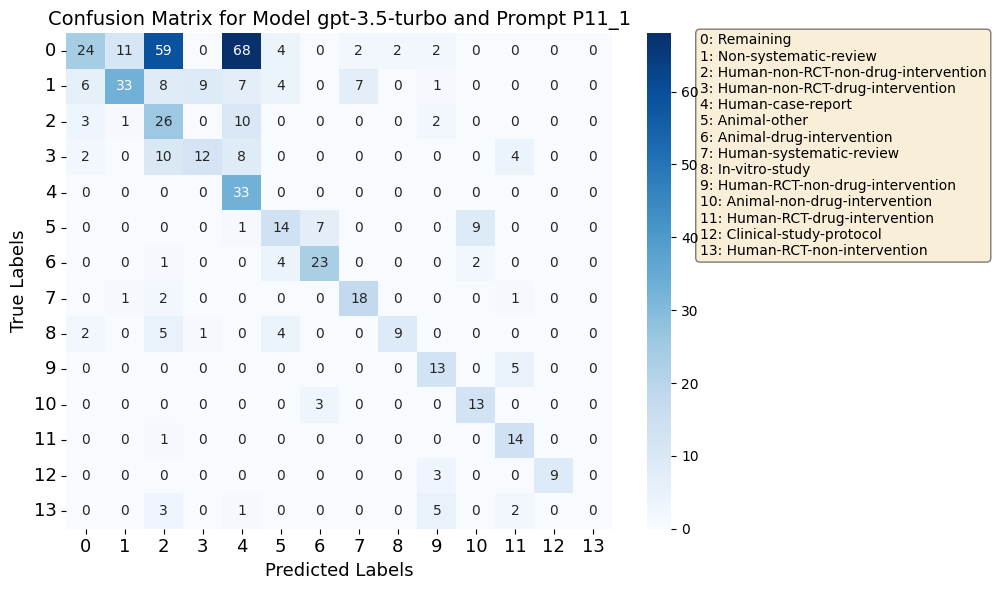

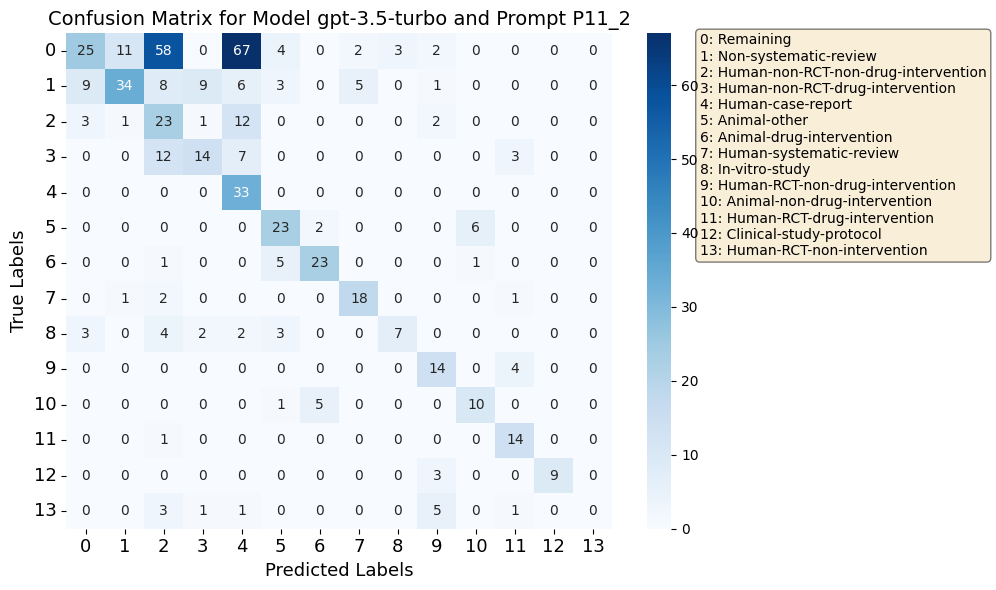

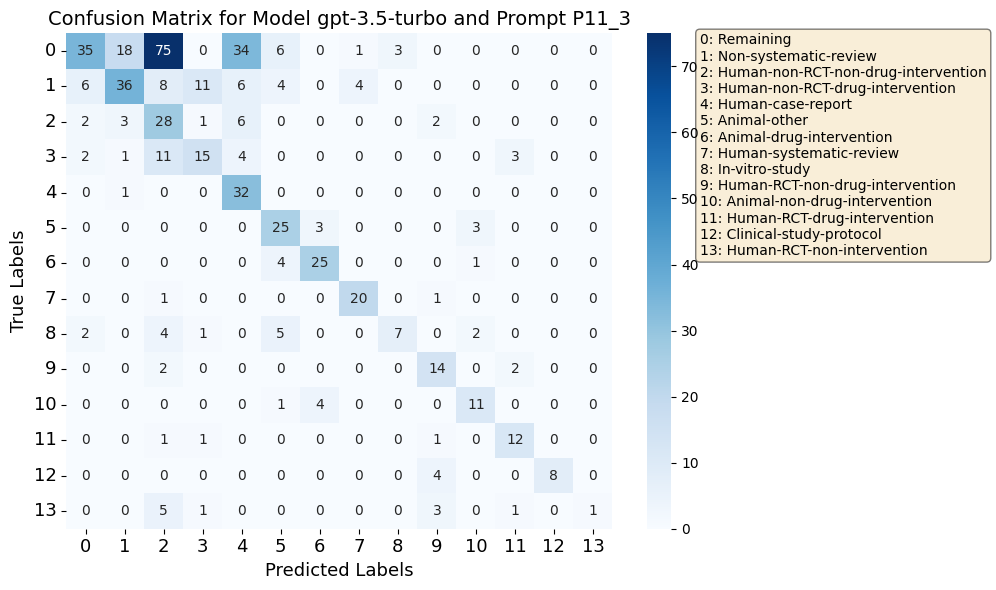

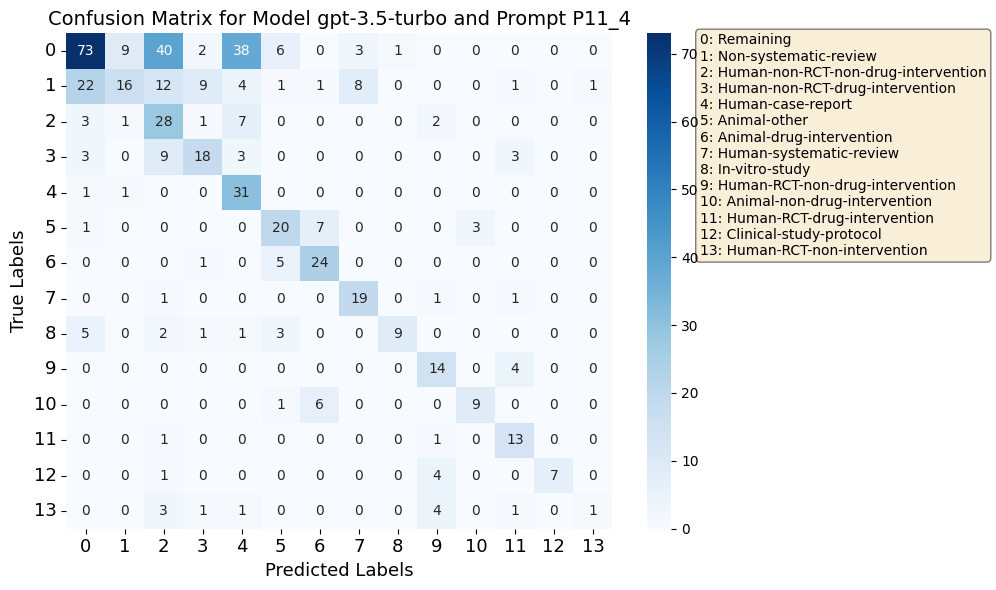

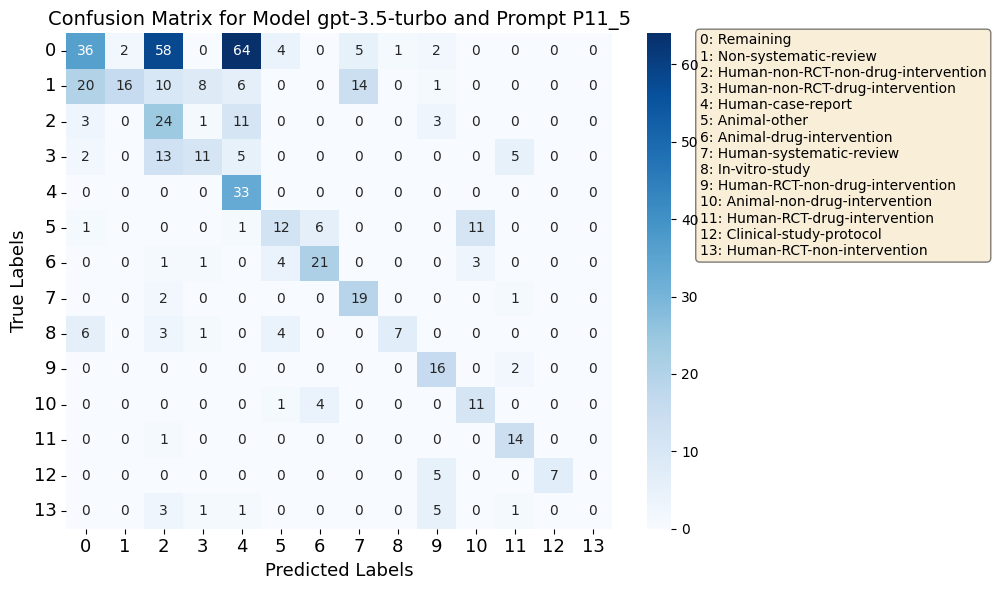

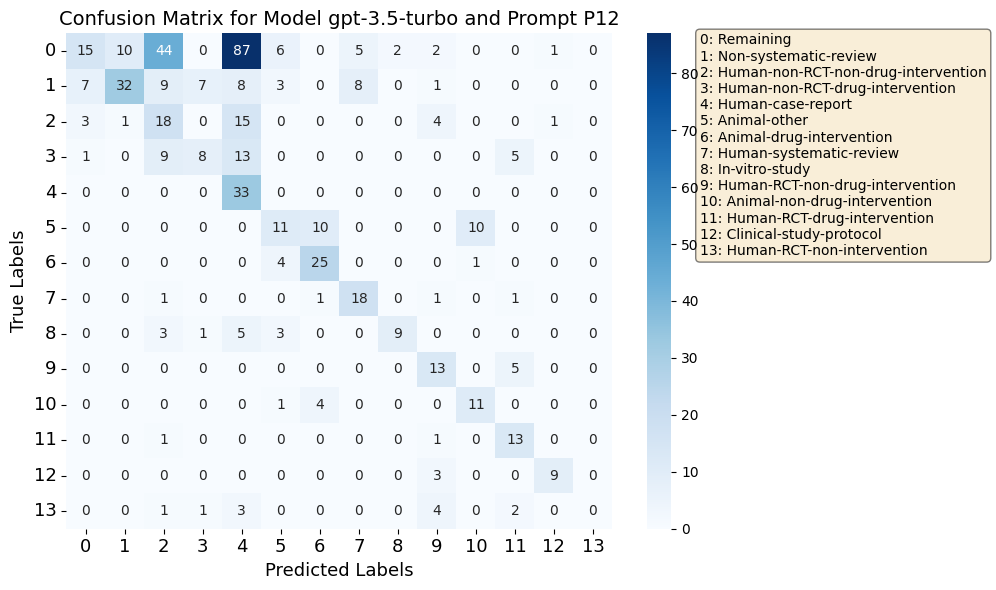

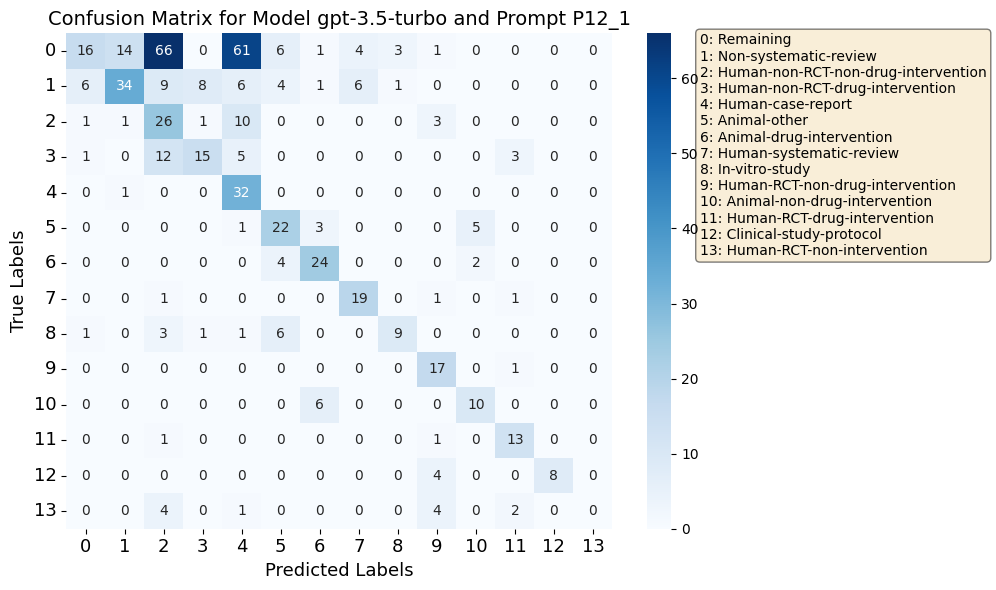

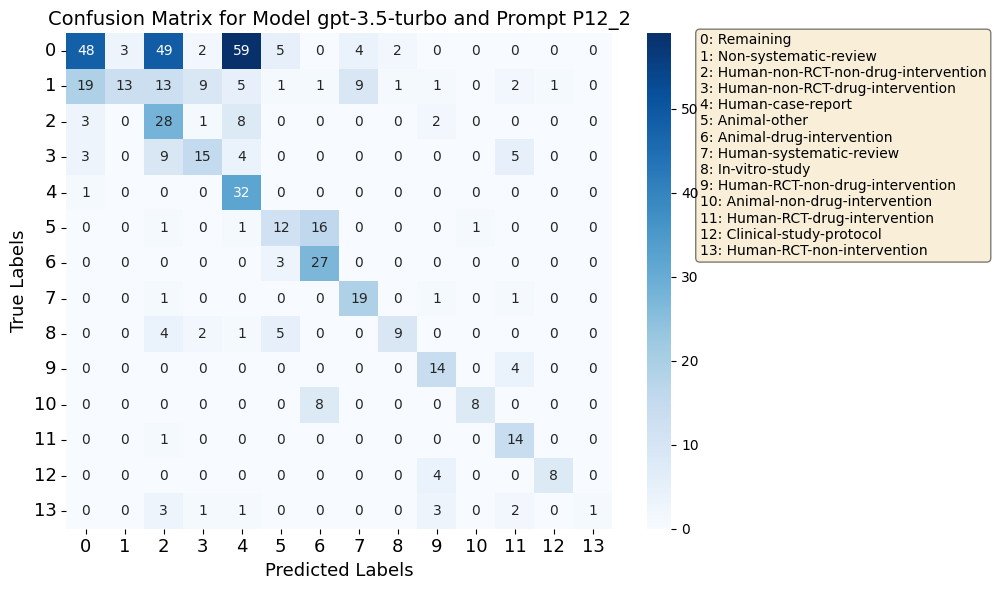

In [640]:
target_label_col = 'accepted_label_numerical'
eval_type = 'multi_label'
all_reports_df, summary_df = evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, csv_file_suffix="all_prompts")


In [641]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.454,"(0.351, 0.539)",0.331,"(0.292, 0.371)",0.261,"(0.22, 0.305)",0.331,"(0.292, 0.373)",P1
1,0.450,"(0.292, 0.652)",0.279,"(0.243, 0.318)",0.203,"(0.167, 0.242)",0.279,"(0.242, 0.316)",P2
2,0.584,"(0.513, 0.64)",0.453,"(0.412, 0.494)",0.430,"(0.386, 0.476)",0.453,"(0.412, 0.496)",P3_1
3,0.556,"(0.487, 0.614)",0.451,"(0.41, 0.494)",0.427,"(0.382, 0.472)",0.451,"(0.41, 0.494)",P3_2
4,0.566,"(0.479, 0.635)",0.434,"(0.391, 0.478)",0.400,"(0.357, 0.445)",0.434,"(0.393, 0.476)",P3_3
5,0.570,"(0.5, 0.622)",0.448,"(0.406, 0.491)",0.427,"(0.381, 0.472)",0.448,"(0.404, 0.489)",P3_4
6,0.563,"(0.498, 0.611)",0.434,"(0.393, 0.476)",0.416,"(0.372, 0.461)",0.434,"(0.393, 0.476)",P4_1
7,0.506,"(0.441, 0.556)",0.414,"(0.371, 0.457)",0.392,"(0.347, 0.437)",0.414,"(0.373, 0.457)",P4_2
8,0.608,"(0.54, 0.65)",0.511,"(0.466, 0.552)",0.498,"(0.452, 0.542)",0.511,"(0.468, 0.552)",P5
9,0.591,"(0.536, 0.631)",0.541,"(0.5, 0.584)",0.532,"(0.487, 0.575)",0.541,"(0.5, 0.584)",P6


In [642]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support,Prompt ID
class,,,,,,,,,,
Remaining,0.412,0.041,0.074,0.672,"(0.216, 0.64)","(0.02, 0.082)","(0.016, 0.132)","(0.631, 0.711)",172,P1
Non-systematic-review,0.778,0.093,0.167,0.869,"(0.453, 0.937)","(0.046, 0.18)","(0.054, 0.279)","(0.838, 0.895)",75,P1
Human-non-RCT-non-drug-intervention,0.148,0.500,0.228,0.734,"(0.099, 0.216)","(0.355, 0.645)","(0.144, 0.313)","(0.695, 0.77)",42,P1
Human-non-RCT-drug-intervention,0.385,0.139,0.204,0.927,"(0.177, 0.645)","(0.061, 0.287)","(0.051, 0.357)","(0.902, 0.946)",36,P1
Human-case-report,0.277,1.000,0.434,0.839,"(0.205, 0.364)","(0.896, 1.0)","(0.335, 0.534)","(0.805, 0.868)",33,P1
...,...,...,...,...,...,...,...,...,...,...
Human-RCT-non-intervention,1.000,0.091,0.167,0.981,"(0.207, 1.0)","(0.016, 0.377)","(-0.121, 0.454)","(0.966, 0.99)",11,P12_2
micro,0.464,0.464,0.464,NaN,"(0.422, 0.507)","(0.422, 0.507)","(0.422, 0.507)",NaN,534,P12_2
macro,0.619,0.575,0.510,NaN,"(nan, nan)","(nan, nan)","(0.482, 0.539)",NaN,534,P12_2


## Format Results and Generate LateX

In [449]:
model = "gpt-4-turbo-preview"

prompt_ids_to_eval = ["P6", "P7", "P11_3", "P11_4"]
summary_gpt4_raw_1 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P1", "P4_1", "P5"]
summary_gpt4_raw_2 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P12_2"]
summary_gpt4_raw_3 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

summary_gpt4_raw = pd.concat([summary_gpt4_raw_1,summary_gpt4_raw_2, summary_gpt4_raw_3]) 
summary_gpt4_raw

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.709,"(0.665, 0.744)",0.603,"(0.562, 0.644)",0.600,"(0.555, 0.642)",0.603,"(0.562, 0.644)",P6
1,0.584,"(0.485, 0.657)",0.459,"(0.418, 0.502)",0.402,"(0.355, 0.447)",0.459,"(0.418, 0.502)",P7
2,0.696,"(0.646, 0.736)",0.588,"(0.547, 0.631)",0.582,"(0.536, 0.624)",0.588,"(0.546, 0.629)",P11_3
3,0.703,"(0.658, 0.74)",0.601,"(0.56, 0.642)",0.596,"(0.552, 0.638)",0.601,"(0.56, 0.642)",P11_4
0,0.590,"(0.519, 0.651)",0.472,"(0.429, 0.515)",0.428,"(0.382, 0.474)",0.472,"(0.429, 0.515)",P1
1,0.638,"(0.584, 0.684)",0.556,"(0.513, 0.597)",0.534,"(0.488, 0.578)",0.556,"(0.515, 0.597)",P4_1
2,0.701,"(0.652, 0.738)",0.592,"(0.551, 0.633)",0.588,"(0.546, 0.63)",0.592,"(0.549, 0.632)",P5
0,0.682,"(0.631, 0.72)",0.569,"(0.526, 0.61)",0.563,"(0.519, 0.606)",0.569,"(0.528, 0.61)",P12_2


In [651]:
# Case of combining separately evaluated prompt files

model = "gpt-3.5-turbo"

prompt_ids_to_eval = ["P5"]
summary_gpt3_raw_1 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P6"]
summary_gpt3_raw_2 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P1"]
summary_gpt3_raw_3 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P7"]
summary_gpt3_raw_4 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P3_3","P3_4","P4_1","P4_2"]
summary_gpt3_raw_5 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P11","P11_1","P11_2","P11_3"]
summary_gpt3_raw_6 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P12_2"]
summary_gpt3_raw_7 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P11_4","P11_5","P12"]
summary_gpt3_raw_8 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

summary_gpt3_raw = pd.concat([summary_gpt3_raw_1,summary_gpt3_raw_2, summary_gpt3_raw_3, summary_gpt3_raw_4, summary_gpt3_raw_5, summary_gpt3_raw_6, summary_gpt3_raw_7, summary_gpt3_raw_8]) 
summary_gpt3_raw

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.608,"(0.54, 0.65)",0.511,"(0.468, 0.552)",0.498,"(0.452, 0.544)",0.511,"(0.47, 0.554)",P5
0,0.591,"(0.536, 0.632)",0.541,"(0.498, 0.584)",0.532,"(0.487, 0.576)",0.541,"(0.498, 0.582)",P6
0,0.454,"(0.354, 0.543)",0.331,"(0.292, 0.371)",0.261,"(0.22, 0.303)",0.331,"(0.29, 0.373)",P1
0,0.467,"(0.335, 0.588)",0.305,"(0.266, 0.345)",0.229,"(0.19, 0.269)",0.305,"(0.266, 0.345)",P7
0,0.566,"(0.481, 0.634)",0.434,"(0.393, 0.476)",0.400,"(0.354, 0.444)",0.434,"(0.391, 0.478)",P3_3
1,0.570,"(0.502, 0.624)",0.448,"(0.406, 0.489)",0.427,"(0.384, 0.473)",0.448,"(0.404, 0.489)",P3_4
2,0.563,"(0.499, 0.611)",0.434,"(0.393, 0.476)",0.416,"(0.371, 0.462)",0.434,"(0.393, 0.476)",P4_1
3,0.506,"(0.442, 0.556)",0.414,"(0.373, 0.457)",0.392,"(0.347, 0.437)",0.414,"(0.373, 0.457)",P4_2
0,0.584,"(0.509, 0.641)",0.442,"(0.399, 0.485)",0.417,"(0.371, 0.461)",0.442,"(0.401, 0.483)",P11
1,0.589,"(0.52, 0.643)",0.451,"(0.41, 0.494)",0.428,"(0.382, 0.473)",0.451,"(0.41, 0.494)",P11_1


In [658]:
# case when the prompt files were combined before the evaluation and the evaluation is already in a single file

model = "gpt-3.5-turbo"

csv_file_suffix="all_prompts"
summary_gpt3_raw = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{csv_file_suffix}_with_ci.csv", index_col=0)
summary_gpt3_raw

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.454,"(0.351, 0.539)",0.331,"(0.292, 0.371)",0.261,"(0.22, 0.305)",0.331,"(0.292, 0.373)",P1
1,0.450,"(0.292, 0.652)",0.279,"(0.243, 0.318)",0.203,"(0.167, 0.242)",0.279,"(0.242, 0.316)",P2
2,0.584,"(0.513, 0.64)",0.453,"(0.412, 0.494)",0.430,"(0.386, 0.476)",0.453,"(0.412, 0.496)",P3_1
3,0.556,"(0.487, 0.614)",0.451,"(0.41, 0.494)",0.427,"(0.382, 0.472)",0.451,"(0.41, 0.494)",P3_2
4,0.566,"(0.479, 0.635)",0.434,"(0.391, 0.478)",0.400,"(0.357, 0.445)",0.434,"(0.393, 0.476)",P3_3
5,0.570,"(0.5, 0.622)",0.448,"(0.406, 0.491)",0.427,"(0.381, 0.472)",0.448,"(0.404, 0.489)",P3_4
6,0.563,"(0.498, 0.611)",0.434,"(0.393, 0.476)",0.416,"(0.372, 0.461)",0.434,"(0.393, 0.476)",P4_1
7,0.506,"(0.441, 0.556)",0.414,"(0.371, 0.457)",0.392,"(0.347, 0.437)",0.414,"(0.373, 0.457)",P4_2
8,0.608,"(0.54, 0.65)",0.511,"(0.466, 0.552)",0.498,"(0.452, 0.542)",0.511,"(0.468, 0.552)",P5
9,0.591,"(0.536, 0.631)",0.541,"(0.5, 0.584)",0.532,"(0.487, 0.575)",0.541,"(0.5, 0.584)",P6


In [644]:
map_prompt_to_concept = {
    'P1': 'zero-shot',
    'P2': 'zero-shot',
    'P3_1': 'CC',
    'P3_2': 'CC',
    'P4_1': 'CC',
    'P4_2': 'CC',
    'P5': 'CC',
    'P6': 'CC',
    'P7': 'CoT',
    'P9': 'CoT + CC',
    'P9_1': 'CoT + CC',
    'P10': 'CoT',
    'P11': 'CoT + CC',
    'P11_1': 'CoT + CC',
    'P11_2': 'CoT + CC',
    'P11_3': 'CoT + CC',
    'P11_4': 'CoT + CC',
    'P11_5': 'CoT + CC',
    'P12': '2 CoT + CC',
    'P12_1': '2 CoT + CC',
    'P12_2': '2 CoT + CC'
}

In [645]:
# Custom sorting function
def custom_sort(prompt):
    import re
    # Extract numbers from the prompt
    numbers = re.findall(r'\d+', prompt)
    if numbers:
        # Primary sort by the first number, secondary sort by the full string
        return (int(numbers[0]), prompt)
    return (float('inf'), prompt)  # Handles cases without numbers
    
def format_summary_for_latex_report(summary_df, map_prompt_to_concept):
    summary_df = summary_df.copy()
    
    # Concatenating each metric with its CI
    summary_df['Precision (CI)'] = summary_df['precision'].astype(str) + ' ' + summary_df['precision CI'].astype(str)
    summary_df['Recall (CI)'] = summary_df['recall'].astype(str) + ' ' + summary_df['recall CI'].astype(str)
    summary_df['F1-Score (CI)'] = summary_df['f1-score'].astype(str) + ' ' + summary_df['f1-score CI'].astype(str)
    summary_df['Accuracy (CI)'] = summary_df['accuracy'].astype(str) + ' ' + summary_df['accuracy CI'].astype(str)
    
    # Dropping old columns
    summary_df.drop(columns=['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI'], inplace=True)
    
    # Rename 'Prompt ID' to 'Prompt'
    summary_df.rename(columns={'Prompt ID': 'Prompt'}, inplace=True)
    
    # Apply the mapping
    summary_df['Concept'] = summary_df['Prompt'].map(map_prompt_to_concept)
    
    # Rearrange the columns to put 'Concept' after 'Prompt'
    summary_df = summary_df[['Prompt', 'Concept', 'Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)']]

    summary_df['sort_key'] = summary_df['Prompt'].apply(custom_sort)
    summary_df.sort_values('sort_key', inplace=True)
    summary_df.drop('sort_key', inplace=True, axis=1)
    
    return summary_df
    

In [646]:
summary_gpt4 = format_summary_for_latex_report(summary_gpt4_raw, map_prompt_to_concept)
summary_gpt4['Model'] = 'gpt-4'
summary_gpt4

,Prompt,Concept,Precision (CI),Recall (CI),F1-Score (CI),Accuracy (CI),Model
0,P1,zero-shot,"0.59 (0.519, 0.651)","0.472 (0.429, 0.515)","0.428 (0.382, 0.474)","0.472 (0.429, 0.515)",gpt-4
1,P4_1,CC,"0.638 (0.584, 0.684)","0.556 (0.513, 0.597)","0.534 (0.488, 0.578)","0.556 (0.515, 0.597)",gpt-4
2,P5,CC,"0.701 (0.652, 0.738)","0.592 (0.551, 0.633)","0.588 (0.546, 0.63)","0.592 (0.549, 0.632)",gpt-4
0,P6,CC,"0.709 (0.665, 0.744)","0.603 (0.562, 0.644)","0.6 (0.555, 0.642)","0.603 (0.562, 0.644)",gpt-4
1,P7,CoT,"0.584 (0.485, 0.657)","0.459 (0.418, 0.502)","0.402 (0.355, 0.447)","0.459 (0.418, 0.502)",gpt-4
2,P11_3,CoT + CC,"0.696 (0.646, 0.736)","0.588 (0.547, 0.631)","0.582 (0.536, 0.624)","0.588 (0.546, 0.629)",gpt-4
3,P11_4,CoT + CC,"0.703 (0.658, 0.74)","0.601 (0.56, 0.642)","0.596 (0.552, 0.638)","0.601 (0.56, 0.642)",gpt-4
0,P12_2,2 CoT + CC,"0.682 (0.631, 0.72)","0.569 (0.526, 0.61)","0.563 (0.519, 0.606)","0.569 (0.528, 0.61)",gpt-4


In [647]:
print(summary_gpt4.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

\begin{tabular}{lllllll}
\toprule
Prompt & Concept & Precision (CI) & Recall (CI) & F1-Score (CI) & Accuracy (CI) & Model \\
\midrule
P1 & zero-shot & 0.59 (0.519, 0.651) & 0.472 (0.429, 0.515) & 0.428 (0.382, 0.474) & 0.472 (0.429, 0.515) & gpt-4 \\
P4\_1 & CC & 0.638 (0.584, 0.684) & 0.556 (0.513, 0.597) & 0.534 (0.488, 0.578) & 0.556 (0.515, 0.597) & gpt-4 \\
P5 & CC & 0.701 (0.652, 0.738) & 0.592 (0.551, 0.633) & 0.588 (0.546, 0.63) & 0.592 (0.549, 0.632) & gpt-4 \\
P6 & CC & 0.709 (0.665, 0.744) & 0.603 (0.562, 0.644) & 0.6 (0.555, 0.642) & 0.603 (0.562, 0.644) & gpt-4 \\
P7 & CoT & 0.584 (0.485, 0.657) & 0.459 (0.418, 0.502) & 0.402 (0.355, 0.447) & 0.459 (0.418, 0.502) & gpt-4 \\
P11\_3 & CoT + CC & 0.696 (0.646, 0.736) & 0.588 (0.547, 0.631) & 0.582 (0.536, 0.624) & 0.588 (0.546, 0.629) & gpt-4 \\
P11\_4 & CoT + CC & 0.703 (0.658, 0.74) & 0.601 (0.56, 0.642) & 0.596 (0.552, 0.638) & 0.601 (0.56, 0.642) & gpt-4 \\
P12\_2 & 2 CoT + CC & 0.682 (0.631, 0.72) & 0.569 (0.526, 0.61) &

In [648]:
summary_gpt3 = format_summary_for_latex_report(summary_gpt3_raw, map_prompt_to_concept)
summary_gpt3['Model'] = 'gpt-3.5'
summary_gpt3 = summary_gpt3.dropna(subset=['Concept'])
summary_gpt3

,Prompt,Concept,Precision (CI),Recall (CI),F1-Score (CI),Accuracy (CI),Model
0,P1,zero-shot,"0.454 (0.351, 0.539)","0.331 (0.292, 0.371)","0.261 (0.22, 0.305)","0.331 (0.292, 0.373)",gpt-3.5
1,P2,zero-shot,"0.45 (0.292, 0.652)","0.279 (0.243, 0.318)","0.203 (0.167, 0.242)","0.279 (0.242, 0.316)",gpt-3.5
2,P3_1,CC,"0.584 (0.513, 0.64)","0.453 (0.412, 0.494)","0.43 (0.386, 0.476)","0.453 (0.412, 0.496)",gpt-3.5
3,P3_2,CC,"0.556 (0.487, 0.614)","0.451 (0.41, 0.494)","0.427 (0.382, 0.472)","0.451 (0.41, 0.494)",gpt-3.5
6,P4_1,CC,"0.563 (0.498, 0.611)","0.434 (0.393, 0.476)","0.416 (0.372, 0.461)","0.434 (0.393, 0.476)",gpt-3.5
7,P4_2,CC,"0.506 (0.441, 0.556)","0.414 (0.371, 0.457)","0.392 (0.347, 0.437)","0.414 (0.373, 0.457)",gpt-3.5
8,P5,CC,"0.608 (0.54, 0.65)","0.511 (0.466, 0.552)","0.498 (0.452, 0.542)","0.511 (0.468, 0.552)",gpt-3.5
9,P6,CC,"0.591 (0.536, 0.631)","0.541 (0.5, 0.584)","0.532 (0.487, 0.575)","0.541 (0.5, 0.584)",gpt-3.5
10,P7,CoT,"0.467 (0.334, 0.589)","0.305 (0.266, 0.345)","0.229 (0.19, 0.269)","0.305 (0.268, 0.345)",gpt-3.5
11,P9,CoT + CC,"0.542 (0.453, 0.616)","0.41 (0.371, 0.453)","0.375 (0.332, 0.42)","0.41 (0.369, 0.453)",gpt-3.5


In [650]:
summary_gpt3.drop(columns=['Model', 'Accuracy (CI)'], inplace=True)

print(summary_gpt3.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

\begin{tabular}{lllll}
\toprule
Prompt & Concept & Precision (CI) & Recall (CI) & F1-Score (CI) \\
\midrule
P1 & zero-shot & 0.454 (0.351, 0.539) & 0.331 (0.292, 0.371) & 0.261 (0.22, 0.305) \\
P2 & zero-shot & 0.45 (0.292, 0.652) & 0.279 (0.243, 0.318) & 0.203 (0.167, 0.242) \\
P3\_1 & CC & 0.584 (0.513, 0.64) & 0.453 (0.412, 0.494) & 0.43 (0.386, 0.476) \\
P3\_2 & CC & 0.556 (0.487, 0.614) & 0.451 (0.41, 0.494) & 0.427 (0.382, 0.472) \\
P4\_1 & CC & 0.563 (0.498, 0.611) & 0.434 (0.393, 0.476) & 0.416 (0.372, 0.461) \\
P4\_2 & CC & 0.506 (0.441, 0.556) & 0.414 (0.371, 0.457) & 0.392 (0.347, 0.437) \\
P5 & CC & 0.608 (0.54, 0.65) & 0.511 (0.466, 0.552) & 0.498 (0.452, 0.542) \\
P6 & CC & 0.591 (0.536, 0.631) & 0.541 (0.5, 0.584) & 0.532 (0.487, 0.575) \\
P7 & CoT & 0.467 (0.334, 0.589) & 0.305 (0.266, 0.345) & 0.229 (0.19, 0.269) \\
P9 & CoT + CC & 0.542 (0.453, 0.616) & 0.41 (0.371, 0.453) & 0.375 (0.332, 0.42) \\
P9\_1 & CoT + CC & 0.521 (0.444, 0.589) & 0.406 (0.365, 0.448) & 0.375 

### combine gpt-3.5 and gpt-4 results in one table

In [459]:
# Combine the DataFrames
combined_df = pd.concat([summary_gpt4, summary_gpt3])

# Pivot table with multi-level columns for metrics and models as subcolumns
pivot_df = combined_df.pivot_table(
    index=['Prompt', 'Concept'],
    columns='Model',
    values=['Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)'],
    aggfunc='first'
)

# Simplify the MultiIndex in columns
pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]
pivot_df = pivot_df.reset_index()

pivot_df['sort_key'] = pivot_df['Prompt'].apply(custom_sort)
pivot_df.sort_values('sort_key', inplace=True)
pivot_df.drop('sort_key', inplace=True, axis=1)

pivot_df

,Prompt,Concept,Accuracy (CI) gpt-3.5,Accuracy (CI) gpt-4,F1-Score (CI) gpt-3.5,F1-Score (CI) gpt-4,Precision (CI) gpt-3.5,Precision (CI) gpt-4,Recall (CI) gpt-3.5,Recall (CI) gpt-4
0,P1,zero-shot,"0.331 (0.29, 0.373)","0.472 (0.429, 0.515)","0.261 (0.22, 0.303)","0.428 (0.382, 0.474)","0.454 (0.354, 0.543)","0.59 (0.519, 0.651)","0.331 (0.292, 0.371)","0.472 (0.429, 0.515)"
4,P4_1,CC,"0.434 (0.393, 0.476)","0.556 (0.515, 0.597)","0.416 (0.371, 0.462)","0.534 (0.488, 0.578)","0.563 (0.499, 0.611)","0.638 (0.584, 0.684)","0.434 (0.393, 0.476)","0.556 (0.513, 0.597)"
5,P5,CC,"0.511 (0.47, 0.554)","0.592 (0.549, 0.632)","0.498 (0.452, 0.544)","0.588 (0.546, 0.63)","0.608 (0.54, 0.65)","0.701 (0.652, 0.738)","0.511 (0.468, 0.552)","0.592 (0.551, 0.633)"
6,P6,CC,"0.541 (0.498, 0.582)","0.603 (0.562, 0.644)","0.532 (0.487, 0.576)","0.6 (0.555, 0.642)","0.591 (0.536, 0.632)","0.709 (0.665, 0.744)","0.541 (0.498, 0.584)","0.603 (0.562, 0.644)"
7,P7,CoT,"0.305 (0.266, 0.345)","0.459 (0.418, 0.502)","0.229 (0.19, 0.269)","0.402 (0.355, 0.447)","0.467 (0.335, 0.588)","0.584 (0.485, 0.657)","0.305 (0.266, 0.345)","0.459 (0.418, 0.502)"
1,P11_3,CoT + CC,"0.504 (0.461, 0.547)","0.588 (0.546, 0.629)","0.488 (0.442, 0.534)","0.582 (0.536, 0.624)","0.636 (0.576, 0.684)","0.696 (0.646, 0.736)","0.504 (0.461, 0.545)","0.588 (0.547, 0.631)"
2,P11_4,CoT + CC,"0.528 (0.485, 0.569)","0.601 (0.56, 0.642)","0.518 (0.473, 0.564)","0.596 (0.552, 0.638)","0.601 (0.542, 0.644)","0.703 (0.658, 0.74)","0.528 (0.485, 0.569)","0.601 (0.56, 0.642)"
3,P12_2,2 CoT + CC,"0.464 (0.421, 0.506)","0.569 (0.528, 0.61)","0.445 (0.399, 0.49)","0.563 (0.519, 0.606)","0.605 (0.545, 0.651)","0.682 (0.631, 0.72)","0.464 (0.423, 0.507)","0.569 (0.526, 0.61)"


In [486]:
pivot_df = pd.DataFrame(pivot_df).drop(columns=['Accuracy (CI) gpt-3.5', 'Accuracy (CI) gpt-4'])


In [489]:
# Creating MultiIndex for columns based on model and metric
new_columns = [
    #('Accuracy', 'gpt-3.5'), ('Accuracy', 'gpt-4'),
    ('Precision', 'gpt-3.5'), ('Precision', 'gpt-4'),
    ('Recall', 'gpt-3.5'), ('Recall', 'gpt-4'),
    ('F1-Score', 'gpt-3.5'), ('F1-Score', 'gpt-4')
]

# Define the new column index as a MultiIndex
multi_index = pd.MultiIndex.from_tuples(new_columns, names=['Metric', 'Model'])

# Create a new DataFrame using only the relevant columns and assign the MultiIndex
new_df = pd.DataFrame(pivot_df, columns=['Prompt', 'Concept', 
                                   #'Accuracy (CI) gpt-3.5', 'Accuracy (CI) gpt-4',
                                   'Precision (CI) gpt-3.5', 'Precision (CI) gpt-4',
                                   'Recall (CI) gpt-3.5', 'Recall (CI) gpt-4',
                                   'F1-Score (CI) gpt-3.5', 'F1-Score (CI) gpt-4',])

# Rename columns to match the MultiIndex
new_df.columns = ['Prompt', 'Concept'] + multi_index.to_flat_index().tolist()

# Set the new column index
new_df.columns = pd.MultiIndex.from_tuples([('', 'Prompt'), ('', 'Concept')] + new_columns)

new_df

Precision                        \
  Prompt     Concept               gpt-3.5                 gpt-4   
0     P1   zero-shot  0.454 (0.354, 0.543)   0.59 (0.519, 0.651)   
4   P4_1          CC  0.563 (0.499, 0.611)  0.638 (0.584, 0.684)   
5     P5          CC    0.608 (0.54, 0.65)  0.701 (0.652, 0.738)   
6     P6          CC  0.591 (0.536, 0.632)  0.709 (0.665, 0.744)   
7     P7         CoT  0.467 (0.335, 0.588)  0.584 (0.485, 0.657)   
1  P11_3    CoT + CC  0.636 (0.576, 0.684)  0.696 (0.646, 0.736)   
2  P11_4    CoT + CC  0.601 (0.542, 0.644)   0.703 (0.658, 0.74)   
3  P12_2  2 CoT + CC  0.605 (0.545, 0.651)   0.682 (0.631, 0.72)   

                 Recall                                    F1-Score  \
                gpt-3.5                 gpt-4               gpt-3.5   
0  0.331 (0.292, 0.371)  0.472 (0.429, 0.515)   0.261 (0.22, 0.303)   
4  0.434 (0.393, 0.476)  0.556 (0.513, 0.597)  0.416 (0.371, 0.462)   
5  0.511 (0.468, 0.552)  0.592 (0.551, 0.633)  0.498 (0.452, 0.544)   
6  0.541 (0.498, 0.584)  0.603 (0.562, 0.644)  0.532 (0.487, 0.576)   
7  0.305 (0.266, 0.345)  0.459 (0.418, 0.502)   0.229 (0.19, 0.269)   
1  0.504 (0.461, 0.545)  0.588 (0.547, 0.631)  0.488 (0.442, 0.534)   
2  0.528 (0.485, 0.569)   0.601 (0.56, 0.642)  0.518 (0.473, 0.564)   
3  0.464 (0.423, 0.507)   0.569 (0.526, 0.61)   0.445 (0.399, 0.49)   

                         
                  gpt-4  
0  0.428 (0.382, 0.474)  
4  0.534 (0.488, 0.578)  
5   0.588 (0.546, 0.63)  
6    0.6 (0.555, 0.642)  
7  0.402 (0.355, 0.447)  
1  0.582 (0.536, 0.624)  
2  0.596 (0.552, 0.638)  
3  0.563 (0.519, 0.606)

In [481]:
# Formatter function to convert float to percentage
def to_percentage(x):
    return "{:.1f}%".format(x * 100)

# Define column formatters
formatters = {
    'Prompt': lambda x: x.replace('_', r'\_'),
    'Accuracy (gpt-3.5)': to_percentage,
    'Accuracy (gpt-4)': to_percentage,
    'F1-Score (gpt-3.5)': to_percentage,
    'F1-Score (gpt-4)': to_percentage,
    'Precision (gpt-3.5)': to_percentage,
    'Precision (gpt-4)': to_percentage,
    'Recall (gpt-3.5)': to_percentage,
    'Recall (gpt-4)': to_percentage,
}

In [490]:
print(new_df.to_latex(float_format="%.3f", index=False, formatters={'': lambda x: x.replace('_', r'\_')}))

\begin{tabular}{llllllll}
\toprule
\multicolumn{2}{r}{} & \multicolumn{2}{r}{Precision} & \multicolumn{2}{r}{Recall} & \multicolumn{2}{r}{F1-Score} \\
Prompt & Concept & gpt-3.5 & gpt-4 & gpt-3.5 & gpt-4 & gpt-3.5 & gpt-4 \\
\midrule
P1 & zero-shot & 0.454 (0.354, 0.543) & 0.59 (0.519, 0.651) & 0.331 (0.292, 0.371) & 0.472 (0.429, 0.515) & 0.261 (0.22, 0.303) & 0.428 (0.382, 0.474) \\
P4_1 & CC & 0.563 (0.499, 0.611) & 0.638 (0.584, 0.684) & 0.434 (0.393, 0.476) & 0.556 (0.513, 0.597) & 0.416 (0.371, 0.462) & 0.534 (0.488, 0.578) \\
P5 & CC & 0.608 (0.54, 0.65) & 0.701 (0.652, 0.738) & 0.511 (0.468, 0.552) & 0.592 (0.551, 0.633) & 0.498 (0.452, 0.544) & 0.588 (0.546, 0.63) \\
P6 & CC & 0.591 (0.536, 0.632) & 0.709 (0.665, 0.744) & 0.541 (0.498, 0.584) & 0.603 (0.562, 0.644) & 0.532 (0.487, 0.576) & 0.6 (0.555, 0.642) \\
P7 & CoT & 0.467 (0.335, 0.588) & 0.584 (0.485, 0.657) & 0.305 (0.266, 0.345) & 0.459 (0.418, 0.502) & 0.229 (0.19, 0.269) & 0.402 (0.355, 0.447) \\
P11_3 & CoT + CC & 

### archive for reference

In [ ]:
def evaluate_predictions(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=range(len(label_to_numerical)), target_names=[numerical_to_label[i] for i in range(len(label_to_numerical))])

        
        # Create DataFrame from report
        report_df = pd.DataFrame(report).transpose()
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        summary = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{prompt_id}_{eval_type}.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_{data_type}_test_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    summary_df.to_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    #all_reports_df.to_csv(f"evaluations/{model}_enriched_test_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    #summary_df.to_csv(f"evaluations/{model}_enriched_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df
